In [1]:
pip install GoogleNews newspaper3k networkx

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 0.0/7.4 MB ? eta -:--:--
     ----------- ---------------------------- 2.1/7.4 MB 10.7 MB/s eta 0:00:01
     ------------------------- -------------- 4.7/7.4 MB 5.4 MB/s eta 0:00:01
     ---------------------------------------  7.3/7.4 MB 7.0 MB/s eta 0:00:01
     ---------------------------------------- 7.4/7.4 MB 6.6 MB/s  0:00:01
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pypr

Mulai mencari berita... (Mohon tunggu sebentar)
🔍 Sedang mencari topik: Harga Cabai Naik...
🔍 Sedang mencari topik: Harga Beras Mahal...
🔍 Sedang mencari topik: Stok Bawang Merah...

✅ Berhasil mendapatkan 61 berita!
Data disimpan di: ../data/processed/data_berita_eksternal.csv
                                               Title                Media
0    Harga Cabai di Bengkulu, Turun Rp60 Ribu per Kg      Media Indonesia
1  Harga Kebutuhan di Sejumlah Daerah di Jawa Ten...      Media Indonesia
2  Harga Ayam dan Cabai Naik Jelang Natal dan Tah...     inilahjateng.com
3  Sejumlah Harga Sembako Melejit di Rohul Jelang...  Tribunpekanbaru.com
4  Jelang Nataru 2025/2026, Harga Ayam di Tangera...     Tribunbanten.com

🕸️ Info Graph SNA: 212 Nodes, 323 Edges


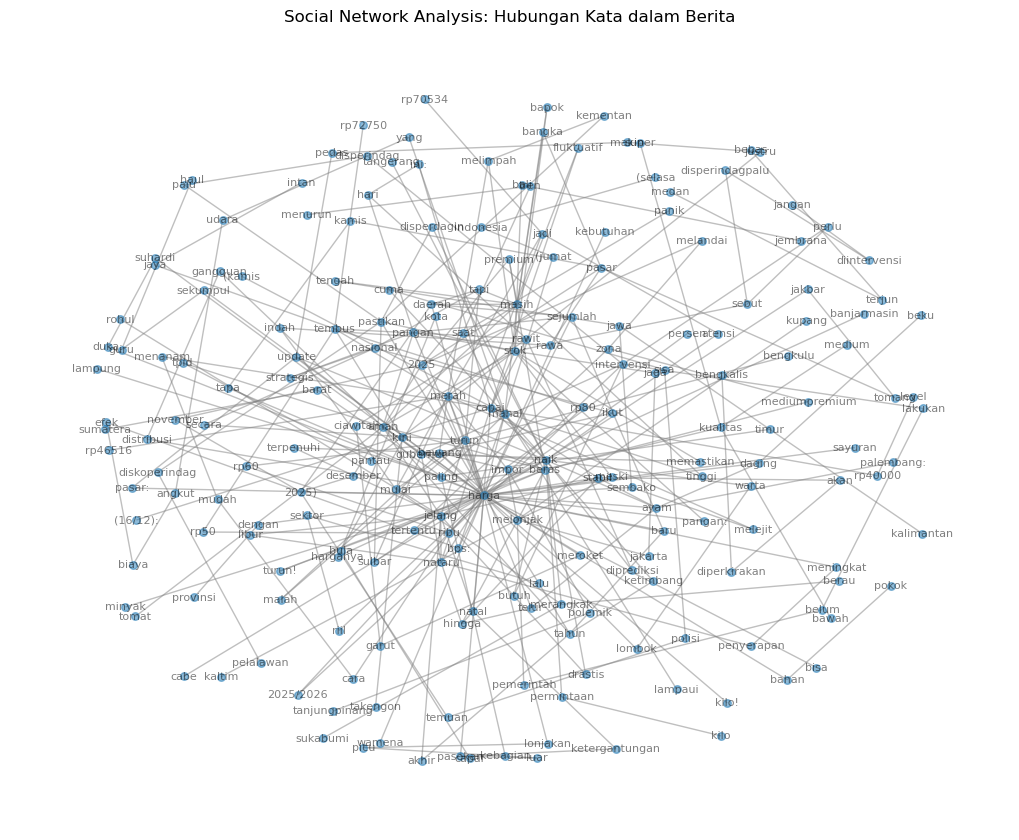

In [2]:
import pandas as pd
from GoogleNews import GoogleNews
import time
import networkx as nx
import matplotlib.pyplot as plt

# --- 1. KONFIGURASI SCRAPING ---
# Kita cari berita berbahasa Indonesia
googlenews = GoogleNews(lang='id', region='ID')

# Kata kunci yang mau dicari (sesuai komoditas kita)
keywords = ['Harga Cabai Naik', 'Harga Beras Mahal', 'Stok Bawang Merah']

all_news = []

print("Mulai mencari berita... (Mohon tunggu sebentar)")

# --- 2. PROSES SCRAPING ---
for key in keywords:
    print(f"🔍 Sedang mencari topik: {key}...")
    googlenews.clear() # Bersihkan pencarian sebelumnya
    googlenews.search(key)
    
    # Ambil halaman 1-2 saja biar tidak terlalu lama
    for page in range(1, 3):
        googlenews.get_page(page)
        hasil = googlenews.result()
        
        # Masukkan ke list
        for berita in hasil:
            all_news.append({
                'Keyword': key,
                'Title': berita['title'],
                'Media': berita['media'],
                'Date': berita['date'],
                'Link': berita['link']
            })
        
        # Jeda biar tidak dikira robot
        time.sleep(2)

# --- 3. SIMPAN DATA EKSTERNAL ---
df_news = pd.DataFrame(all_news)

# Bersihkan duplikat (kadang berita sama muncul 2x)
df_news = df_news.drop_duplicates(subset=['Title'])

if len(df_news) > 0:
    # Simpan ke folder processed
    output_file = '../data/processed/data_berita_eksternal.csv'
    df_news.to_csv(output_file, index=False)
    print(f"\n✅ Berhasil mendapatkan {len(df_news)} berita!")
    print(f"Data disimpan di: {output_file}")
    print(df_news[['Title', 'Media']].head())
else:
    print("❌ Gagal mendapatkan berita. Coba cek koneksi internet atau ganti keyword.")

# --- 4. PREVIEW SNA (Analisis Jejaring Kata) ---
# Kita coba lihat hubungan antar kata dalam judul berita
# Contoh: "Harga" sering muncul bareng "Cabai" atau "Petani"?

if len(df_news) > 0:
    # Gabungkan semua judul jadi satu teks besar
    text_data = " ".join(df_news['Title'].tolist()).lower()
    
    # Hapus karakter aneh
    for char in "-.,|?":
        text_data = text_data.replace(char, "")
    
    words = text_data.split()
    
    # Buat Graph (Jaringan)
    G = nx.Graph()
    
    # Logika: Jika kata A muncul di sebelah kata B, buat garis hubung
    for i in range(len(words)-1):
        w1 = words[i]
        w2 = words[i+1]
        
        # Filter kata pendek (seperti "di", "ke", "dan") biar grafik rapi
        if len(w1) > 3 and len(w2) > 3:
            if G.has_edge(w1, w2):
                G[w1][w2]['weight'] += 1
            else:
                G.add_edge(w1, w2, weight=1)

    print(f"\n🕸️ Info Graph SNA: {G.number_of_nodes()} Nodes, {G.number_of_edges()} Edges")
    
    # Gambar SNA Sederhana
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, k=0.5) # k mengatur jarak antar node
    nx.draw(G, pos, with_labels=True, node_size=30, font_size=8, edge_color="gray", alpha=0.5)
    plt.title("Social Network Analysis: Hubungan Kata dalam Berita")
    plt.show()